## Imports & fetching Data

In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import math
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


### A

In [4]:
# Everything to run the simulation

track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy  


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


In [12]:
# For A and B:

def different_firing_rate_maps(coarse):  
    space_bins = np.arange(0., 200, coarse)
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    
    plt.figure(figsize=(15,5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()
    
interact(different_firing_rate_maps, coarse = widgets.IntSlider(min=1, max=200, value=5.))

interactive(children=(IntSlider(value=5, description='coarse', max=200, min=1), Output()), _dom_classes=('widg…

<function __main__.different_firing_rate_maps(coarse)>

We see that if we decrease the coarseness we get a more precise resolution of the cells' activity and vice versa. Thus we want a low coarseness.

### B

In [ ]:
noise_firing_rate_list = np.arange(0.1, 0.9, 0.2)

for noise_firing_rate in noise_firing_rate_list:
    
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
        
        

The baseline noise variable is called 'noise_firing_rate' which is set to 0.1 by default. 

> What are meant with different approaches? What are the options?

### C

In [ ]:
def different_firing_rate_maps_gaussian(coarse, width, noise_firing_rate):
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    space_bins = np.arange(0., width, coarse)
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    
    plt.figure(figsize=(15,5))
    plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()
    
interact(different_firing_rate_maps, coarse = widgets.IntSlider(min=1, max=200, value=5.), 
         width = widgets.IntSlider(min=10, max=200, value=200),
         noise_firing_rate = widgets.FloatSlider(min=0.1, max=0.9, value=0.1))

### D

In [ ]:
place_field_center = 1/N_spikes * np.sum L_i 

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

### A

In [6]:
epsilon = 10e-15
spatial_information = np.sum(firing_rate_maps * np.log2((firing_rate_maps+epsilon/np.mean(firing_rate_maps)) * occupancy))
spatial_information_s = spatial_information / np.mean(firing_rate_maps)
print("The spatial information of the simulated place cell data is {0:.2f} bits per second.".format(spatial_information))
print("The value of the second definition spatial information of the simulated place cell data is {0:.2f} bits per spike.".format(spatial_information_s))

The spatial information of the simulated place cell data is 22961.89 bits per second.
The value of the second definition spatial information of the simulated place cell data is 26808.79 bits per spike.


### B

In [1]:
def simulation(pf_rate_coeff = 1, pf_size_coeff = 10, noise_firing_rate = 0.1):
    # Simulation Parameters
    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = 100 # how many cells we are recording
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(pf_size_coeff, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = pf_rate_coeff * np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    # Simulating stuff
    x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
    g = scipy.stats.gamma.pdf(x, 10)

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    
    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = 30 # the number of "video frames" per second 
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps
    
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    # noise_firing_rate = 0.1 # the baseline noise firing rate
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    
    spike_positions = [np.interp(s, t, x) for s in spikes]

    space_bins = np.arange(0., 200., 5.)

    # we compute histograms for each cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 
    
    spatial_information = np.sum(firing_rate_maps * np.log2((firing_rate_maps+epsilon/np.mean(firing_rate_maps)) * occupancy))
    spatial_information_s = spatial_information / np.mean(firing_rate_maps)
    
    return firing_rate_maps, spatial_information, spatial_information_s

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33it/s]


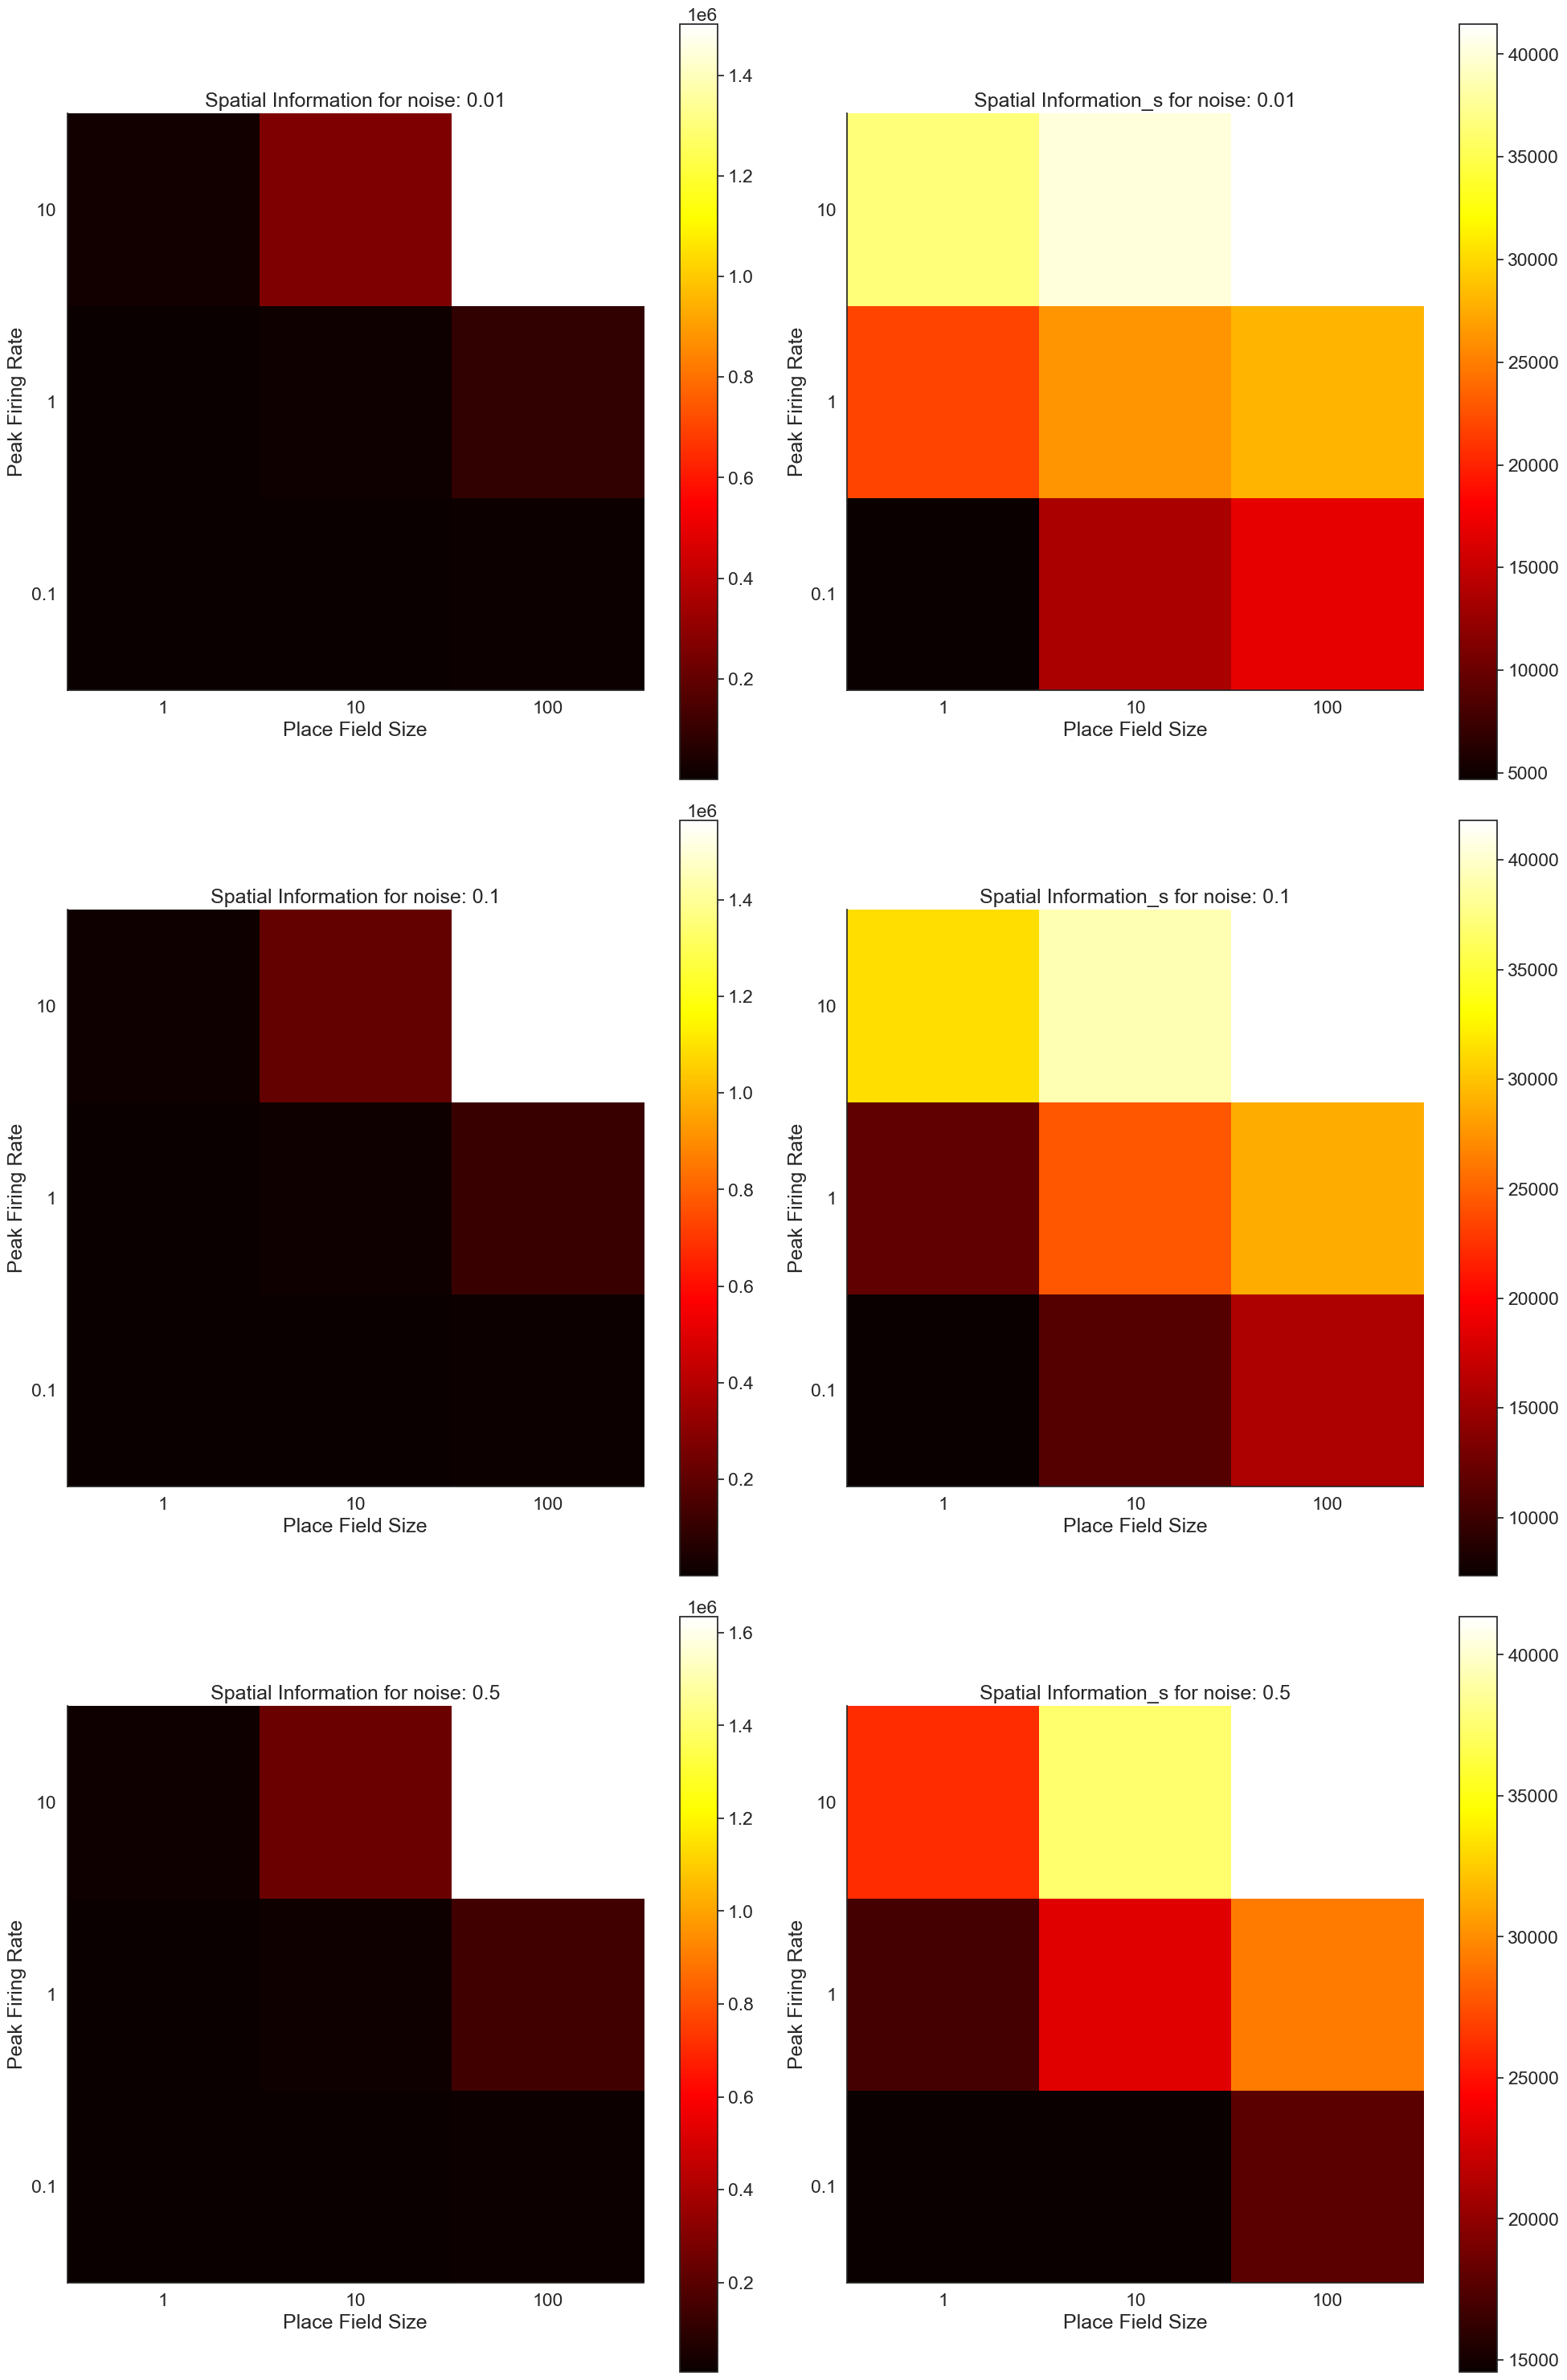

In [11]:
peak_firing_rates = [0.1, 1, 10]
pf_sizes = [1, 10, 100]
noise_levels = [0.01, 0.1, 0.5]
    
fig, axes = plt.subplots(len(noise_levels), 2, figsize=(20, 30))

for index, noise in enumerate(noise_levels):
    spatial_infos = np.zeros((len(peak_firing_rates), len(pf_sizes)))
    spatial_infos_s = np.zeros((len(peak_firing_rates), len(pf_sizes)))
    
       
    for i, pf_rate in enumerate(peak_firing_rates):
        for j, pf_size in enumerate(pf_sizes):
            _, spatial_info, spatial_info_s = simulation(pf_rate, pf_size, noise)
            spatial_infos[i,j] = spatial_info
            spatial_infos_s[i,j] = spatial_info_s

    im1 = axes[index, 0].imshow(spatial_infos, cmap='hot', interpolation='nearest', origin='lower')
    axes[index, 0].set_title('Spatial Information for noise: {}'.format(noise))
    axes[index, 0].set_xlabel('Place Field Size')
    axes[index, 0].set_ylabel('Peak Firing Rate')
    axes[index, 0].set_xticks(np.arange(len(pf_sizes)))
    axes[index, 0].set_yticks(np.arange(len(peak_firing_rates)))
    axes[index, 0].set_xticklabels(pf_sizes)
    axes[index, 0].set_yticklabels(peak_firing_rates)
    fig.colorbar(im1, ax=axes[index, 0])

    im2 = axes[index, 1].imshow(spatial_infos_s, cmap='hot', interpolation='nearest', origin='lower')
    axes[index, 1].set_title('Spatial Information_s for noise: {}'.format(noise))
    axes[index, 1].set_xlabel('Place Field Size')
    axes[index, 1].set_ylabel('Peak Firing Rate')
    axes[index, 1].set_xticks(np.arange(len(pf_sizes)))
    axes[index, 1].set_yticks(np.arange(len(peak_firing_rates)))
    axes[index, 1].set_xticklabels(pf_sizes)
    axes[index, 1].set_yticklabels(peak_firing_rates)
    fig.colorbar(im2, ax=axes[index, 1])
    
plt.tight_layout()
plt.show()


From the plots we can (easily) see, atleast for the alternative definition, that the spatial information increases with peak firing rate, place field size and with a higher noise value. The difference in the plots of the two definitions is very significant. The difference for the original definition $I$, is about a factor 16, and for the alternative definition $I_s$ a factor 8, 4 or even 3 depending on the noise levels. We also overall see much higher values for $I$ who exlode a lot more violently for higher variable values. It is therefore more convenient to use $I_s$ when working with variables over large ranges.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

### A

Text(0, 0.5, 'Position')

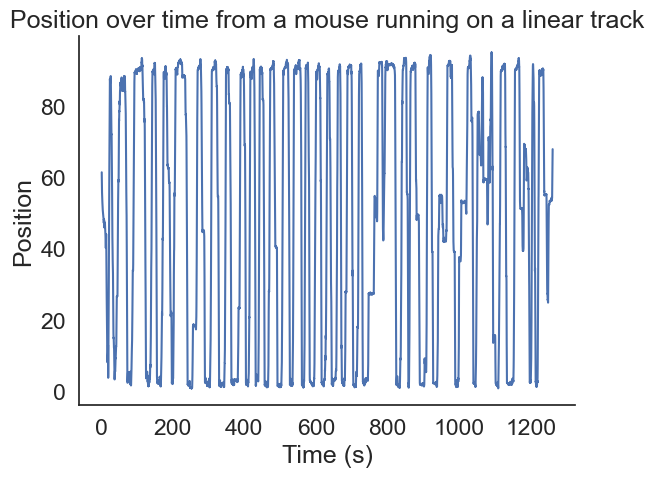

In [7]:
# Import data
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
position = data['x']
time = data['t']
spikes = data['spikes']

plt.title('Position over time from a mouse running on a linear track')
plt.plot(time, position)
plt.xlabel('Time (s)')
plt.ylabel('Position')




### B

### C